# Natural Language Processing in Python

## Case Study: Predict Wine Reviewer Using Review Descriptions

### Introduction 

Performing a case study analysis to use wine review descriptions to predict reviewer. The data set used here was provided by  kaggle wine reivew web site:
https://www.kaggle.com/zynicide/wine-reviews

The task here is to build a machine learning model to predict the wine taster using the review description details


### Part I: Initial Set Up
#### Here we will include header information about the program and import needed packages/functions

Original Author: Stella Liu

Created on: March 14th, 2020

Project: Case Study using NLP

Description: Perform NLP and use ML to predict wine reviewer using unstructure data from the review description

Inputs: Wine review dataset, winemag-data-130k-v2.csv

In [19]:
import azureml.core # core packages, modules and classes for Azure Machine Learning
from azureml.core import Workspace, Datastore, Experiment, Dataset
# from azureml.core import Experiment

import numpy as np # for scientific computing
import pandas as pd # for data manipulation and analysis
import os # way of using operating system dependent functionality
import re # regular expression operations
from collections import Counter

import matplotlib.pyplot as plt # for interactive plots and simple cases of programmatic plot generation
import seaborn as sns # graphic library built on top of Matplotlib
%matplotlib inline

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer # regular expressions to tokenize text, the reverse regex operations
from nltk.corpus import names, stopwords, words # defines a collection of corpus reader classes
from nltk import word_tokenize # Return a tokenized copy of text, using NLTK's recommended word tokenizer

from sklearn.feature_extraction import text # extract features in a format supported by ML algorithms from datasets
from sklearn.model_selection import train_test_split # split data to train and test
from sklearn.feature_extraction.text import CountVectorizer  # count the number of words
from sklearn.feature_extraction.text import TfidfTransformer # compute IDF and TF-IDF scores
from sklearn.feature_extraction.text import TfidfVectorizer # Convert collection of raw documents to a matrix of TF-IDF features
from sklearn.naive_bayes import MultinomialNB, GaussianNB # running the multinomial and gaussian naive Bayes
from sklearn import metrics # calculate model accuracy of the class prediction
from sklearn.cluster import KMeans # K-means clustering algorithm
from sklearn.ensemble import RandomForestClassifier # Import the random forest package  
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report # use for model evaluation
import itertools

SEED = 7

### Part II: Load Dataset 
#### Load the wine dataset from Azure Machine Learning datastore

In [20]:
# Check core SDK version number, and workspace information
ws = Workspace.from_config()
print('SDK version:', azureml.core.VERSION)
# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep=', ')
# set up experiment
experiment_name = 'train-with-datasets'
exp = Experiment(workspace=ws, name=experiment_name)
print(exp)
# load and use dataset directly in training

datastore_name = 'workspaceblobstore'
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(ws, datastore_name)

# data has dimenion 129975 x 14
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'UI/03-11-2020_115959_UTC/winemag-data-130k-v2.csv')])
wine_ogn = dataset.to_pandas_dataframe()
wine_ogn.shape

SDK version: 1.0.83
Experiment(Name: train-with-datasets,
Workspace: ml_learning_ws)


(129975, 14)

### Part III: Exploratory Data Analysis
#### Perform EDA at high level to understand the dataset before modeling

In [21]:
# preview the first 3 rows of the dataset
wine_ogn.head(3)

,Column1,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0.0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87.0,NaN,Sicily & Sardinia,Etna,,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1.0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87.0,15.0,Douro,,,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2.0,US,"Tart and snappy, the flavors of lime flesh and...",,87.0,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [22]:
# view data column names
for col in wine_ogn.columns: 
    print(col)
# decision: keep the fields we need for the modeling
wine_narrow = wine_ogn[['description','taster_name']]

Column1
country
description
designation
points
price
province
region_1
region_2
taster_name
taster_twitter_handle
title
variety
winery


In [23]:
# no missing for the description/reviews
# have missings for the tester_name, need to exam more
# later on found out there are both missing and empty string in tester_name
wine_narrow.info()
wine_narrow.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129975 entries, 0 to 129974
Data columns (total 2 columns):
description    129975 non-null object
taster_name    129970 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


(129975, 2)

#### Learning: 
noticed lots of empty value for the reviewer name
    
#### Decision: 
replace both missing and empty string to value: 'Missing'

remove the 'Missing' from taster(reviewer) field since that is our target variable 

In [24]:
# check review frequency by each reviewer, also good chance to make sure names are unique
# wine_narrow['taster_name'].value_counts()
# in this dataset, we actually have missing for our target, reviewer name, ~20.20%
wine_narrow = wine_narrow.fillna('').replace('','Missing')
wine_narrow['taster_name'].value_counts(normalize = True)

Missing               0.201954
Roger Voss            0.196299
Michael Schachner     0.116438
Kerin O’Keefe         0.082908
Virginie Boone        0.073376
Paul Gregutt          0.073337
Matt Kettmann         0.048717
Joe Czerwinski        0.039600
Sean P. Sullivan      0.038207
Anna Lee C. Iijima    0.033968
Jim Gordon            0.032137
Anne Krebiehl MW      0.028352
Lauren Buzzeo         0.014110
Susan Kostrzewa       0.008348
Mike DeSimone         0.003955
Jeff Jenssen          0.003778
Alexander Peartree    0.003193
Carrie Dykes          0.001069
Fiona Adams           0.000208
Christina Pickard     0.000046
Name: taster_name, dtype: float64

In [25]:
# we now have data dimention 103,726 x 2
wine_narrow_model =  wine_narrow[wine_narrow["taster_name"] != "Missing"]
type(wine_narrow_model)
wine_narrow_model.info()
wine_narrow_model.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103726 entries, 0 to 129974
Data columns (total 2 columns):
description    103726 non-null object
taster_name    103726 non-null object
dtypes: object(2)
memory usage: 2.4+ MB


(103726, 2)

#### Learning: 
when looking at unique tasters, there are 19 unique reviewers
    
#### Decision: 
we will keep the top 10 reviewers who have the most number of reviewes for this case study so we have reasonable number of classes and engough reviews to work with

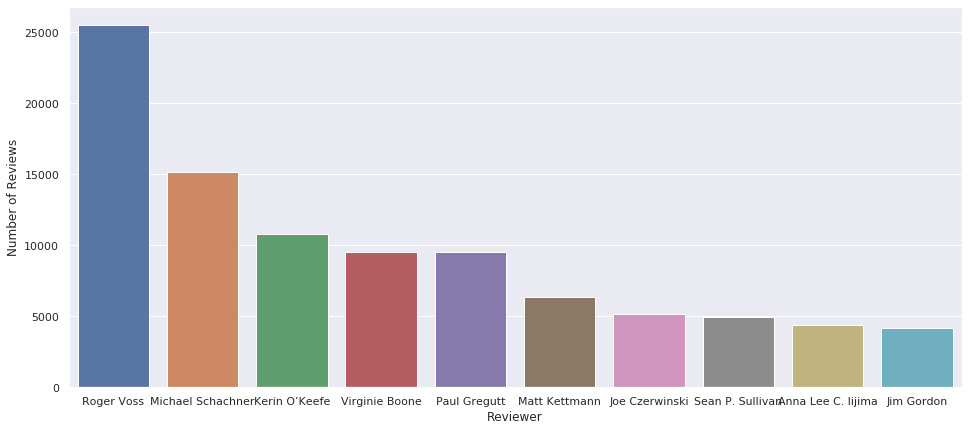

Roger Voss            0.245975
Michael Schachner     0.145904
Kerin O’Keefe         0.103889
Virginie Boone        0.091944
Paul Gregutt          0.091896
Matt Kettmann         0.061045
Joe Czerwinski        0.049621
Sean P. Sullivan      0.047876
Anna Lee C. Iijima    0.042564
Jim Gordon            0.040270
Anne Krebiehl MW      0.035526
Lauren Buzzeo         0.017681
Susan Kostrzewa       0.010460
Mike DeSimone         0.004955
Jeff Jenssen          0.004734
Alexander Peartree    0.004001
Carrie Dykes          0.001340
Fiona Adams           0.000260
Christina Pickard     0.000058
Name: taster_name, dtype: float64

In [26]:
# display the top 10 reviewer
# note that reviewer, Roger Voss, contributed ~25% of the reviews in this dataste
plt.figure(figsize=(16,7))
sns.set(style="darkgrid")
sns.barplot(x=wine_narrow_model.taster_name.value_counts()[:10].index, y=wine_narrow_model.taster_name.value_counts()[:10].values)
plt.xlabel("Reviewer")
plt.ylabel("Number of Reviews")
plt.show()

wine_narrow_model['taster_name'].value_counts(normalize = True)

In [27]:
# keep top 10 reviewer as a start 
counter = Counter(wine_narrow_model['taster_name'].tolist())

top_10_reviewer = {i[0]: idx for idx, i in enumerate(counter.most_common(10))}

wine_narrow_model_10 = wine_narrow_model[wine_narrow_model['taster_name'].map(lambda x: x in top_10_reviewer)]

# by keeping only top 10 reviewer, our data recuded to 95,530 x 2 from 103,726 x 2 
# working with ~92% of the non-missing reviewer data
wine_narrow_model_10.shape
wine_narrow_model_10['taster_name'].value_counts()

Roger Voss            25514
Michael Schachner     15134
Kerin O’Keefe         10776
Virginie Boone         9537
Paul Gregutt           9532
Matt Kettmann          6332
Joe Czerwinski         5147
Sean P. Sullivan       4966
Anna Lee C. Iijima     4415
Jim Gordon             4177
Name: taster_name, dtype: int64

### Part IV: Text Cleaning
#### clean text by keeping letters only, remove white space, remove stop words, etc.

In [28]:
# functioni for text cleaning
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# apply the funcion on review text
wine_narrow_model_10['description_clean'] = wine_narrow_model_10['description'].apply(lambda x: clean_text(x))
wine_narrow_model_10.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,description,taster_name,description_clean
0,"Aromas include tropical fruit, broom, brimston...",Kerin O’Keefe,aromas include tropical fruit broom brimstone ...
1,"This is ripe and fruity, a wine that is smooth...",Roger Voss,this is ripe and fruity a wine that is smooth ...
2,"Tart and snappy, the flavors of lime flesh and...",Paul Gregutt,tart and snappy the flavors of lime flesh and ...
4,"Much like the regular bottling from 2012, this...",Paul Gregutt,much like the regular bottling from this comes...
5,Blackberry and raspberry aromas show a typical...,Michael Schachner,blackberry and raspberry aromas show a typical...


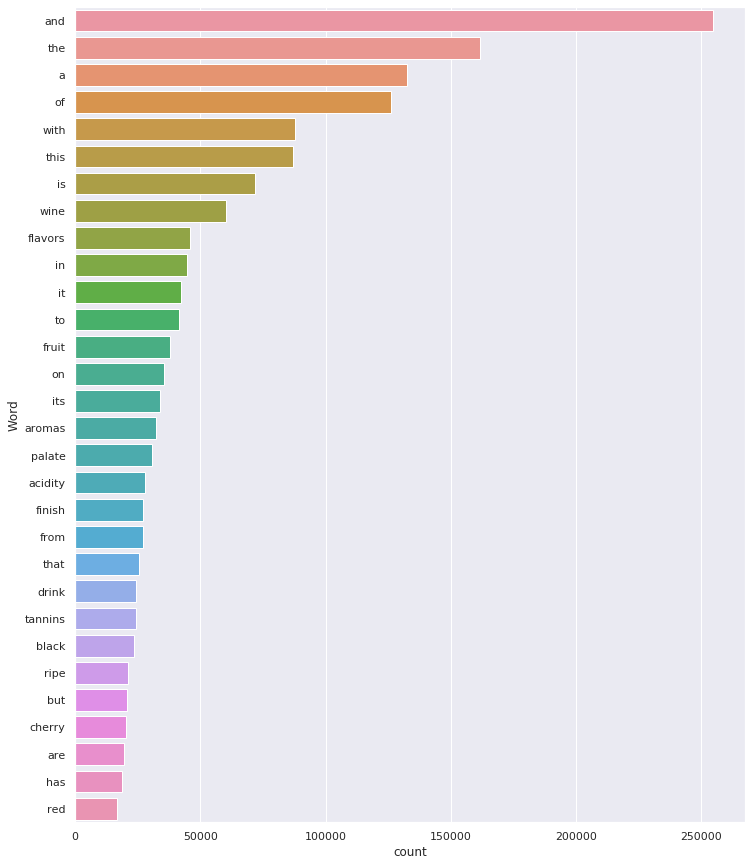

In [29]:
# function to visualize the words and their frequency
def freq_words(x, terms = 50): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top n most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# use function above to print 30 most frequent words 
freq_words(wine_narrow_model_10['description_clean'], 30)

In [30]:
# most of the words above are stopwords: "set of commonly used words in a language"
# these words should be removed so we may focus on the important words instead
# decision: let's remove the stop words

# first, lets create our stopword set 
stopwords_1 = set(stopwords.words('english'))
stopwords_2 = text.ENGLISH_STOP_WORDS
stopwords_all = stopwords_1.union(stopwords_2)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


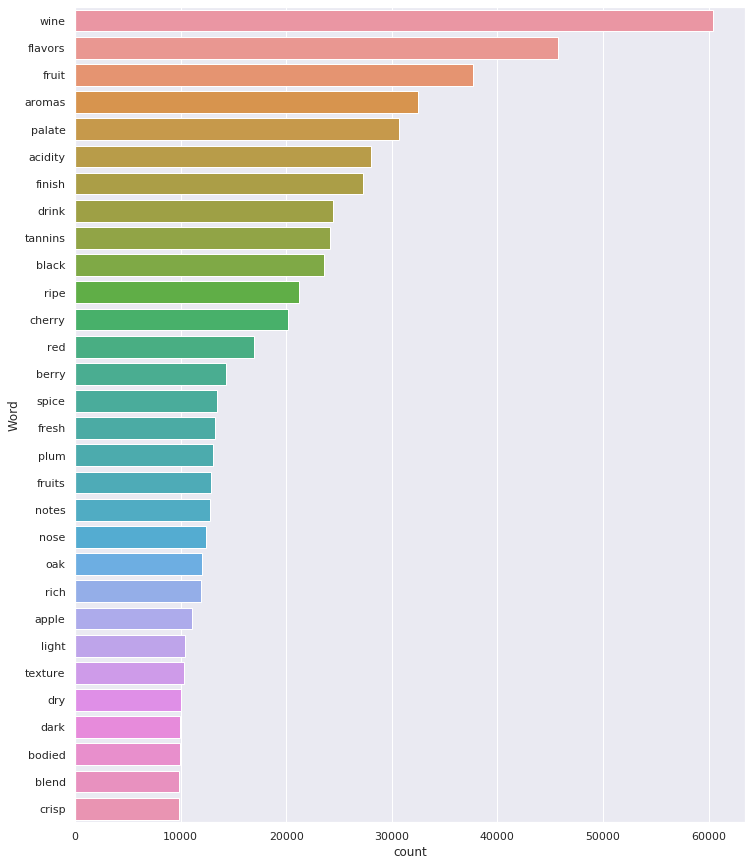

In [31]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords_all]
    return ' '.join(no_stopword_text)

# use function above to check the most frequent terms again
wine_narrow_model_10['description_clean_dense'] = wine_narrow_model_10['description_clean'].apply(lambda x: remove_stopwords(x))

# use function print 30 most frequent words 
# since this dataset is about wine review, it's not surprising that after cleaning of the text, "wine" apears most frequently
freq_words(wine_narrow_model_10['description_clean_dense'], 30)

### Part V: Creat Model Features
#### one hot encoding preprocessing the text using TF-IDF
vectorizing our data and convert our text documents to a matrix of taken counts

In [32]:
# get all the descriptions out to a list
# set reviewer class indicator from 0 to 9 for the top 10 reviewers
description_list = wine_narrow_model_10['description_clean_dense'].tolist()
reviewer_list = [top_10_reviewer[i] for i in wine_narrow_model_10['taster_name'].tolist()]
reviewer_list = np.array(reviewer_list)

#### Learning: 
the most frequently used words like wine, flabors, fruit,... are given least amount of the weight

In [33]:
# Convert a collection of text documents to a matrix of token counts
# create a CountVectorizer to count the number of words (term frequency)
cv = CountVectorizer(max_features=15000)
x_train_counts = cv.fit_transform(description_list)
x_train_counts.shape # 95530 rows (95530 docs) and 15000 columns (15000 unique words) -> since we limited the max features above
# let's view our IDF value sorted in ascending order
# learning: here the most frequent words like wine, flabors, fruit,... are given least amount of the weight
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(x_train_counts)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head()

,idf_weights
wine,1.695190
flavors,1.794722
fruit,2.043230
aromas,2.089941
palate,2.146687


#### Learning: 
The more common the word across documents, the lower its score

more unique a word is to our first document (e.g. ‘unripened’ and ‘brimstone’) the higher the score

we can use Tfidfvectorizer to get the same result with simplier code

In [34]:
# count matrix
# gets the word counts for the documents in a sparse matrix form
count_vector=cv.transform(description_list)
 
# tf-idf scores
# computing the tf-idf scores for your docs
# this is computing the tf * idf  multiplication where your term frequency is weighted by its IDF values
tf_idf_vector=tfidf_transformer.transform(count_vector)
feature_names = cv.get_feature_names()
 
# get tfidf vector for first document
# let’s print the tf-idf values of the first document to see if it makes sense
# placing the tf-idf scores from the first document into a pandas data frame and sorting it in descending order of scores
first_document_vector=tf_idf_vector[0]
# print the scores
# Tf-idf scores of first document
# learning: only certain words have scores
# The more common the word across documents, the lower its score
# more unique a word is to our first document (e.g. ‘unripened’ and ‘brimstone’) the higher the score
# the score makes sense
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
unripened,0.434733
brimstone,0.357013
dried,0.297111
broom,0.282449
overly,0.252239


In [35]:
# using Tfidfvectorizer to get the same result as above
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your documents here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(description_list)
tfidf_vectorizer_vectors.shape # 95530 rows (95530 docs) and 25738 columns (25738 unique words)

# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
unripened,0.434733
brimstone,0.357013
dried,0.297111
broom,0.282449
overly,0.252239


### Part VI: Model 1 - Multinomial Naive Bayse Classifier
#### use multinomial naive bayse classifier to train our data

here we will use multinomial naive bayse classifier for the modeling and review result using cross validation and accuracy percent

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [36]:
# creating the tran and test folds form the dataset as 70-30 split 
# using random_state to set the seed so we will have the same observations placed into train and test 
train_x, test_x, train_y, test_y = train_test_split(tfidf_vectorizer_vectors, reviewer_list, test_size=0.3, random_state=SEED)

#### Learning: 
training the model was very fast at 46.8 ms

In [37]:
# multinomial Naive Bayes classifier is suitable for classification with discrete features
# train the model: Naive bayes is fast
%time clf_mnb = MultinomialNB().fit(train_x, train_y)
print(clf_mnb.coef_.shape) # 10 x 25738

CPU times: user 47.5 ms, sys: 0 ns, total: 47.5 ms
Wall time: 46.8 ms
(10, 25738)


#### Learning: 
when evaluating this model using the test data set, the accuracy of class predictions is at 91.26%

we also used Confusion Matrix and Classification Report below to evaluate the model

In [38]:
# Training predictions, probabilities for each class
train_mnb_predictions = clf_mnb.predict(train_x)
train_mnb_probs = clf_mnb.predict_proba(train_x)[:, 1]

# Actual class predictions, probabilities for each class
mnb_predictions = clf_mnb.predict(test_x)
mnb_probs = clf_mnb.predict_proba(test_x)[:, 1]

# calculate accuracy of class predictions
print("Accuracy: %.2f%%" % ((metrics.accuracy_score(test_y, mnb_predictions)) * 100))

Accuracy: 91.26%


In [39]:
# examine class distribution
# note that we have slight majority class of 0 here
y_test=pd.Series(test_y)
print("=== class distribution ===")
print(y_test.value_counts())
print('\n')
# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 7757
# In this case, we can see that our accuracy (0.9126) is higher than the null accuracy (0.270665)
print("=== null accuracy ===")
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

=== class distribution ===
0    7757
1    4504
2    3217
4    2871
3    2855
5    1857
7    1540
6    1526
8    1293
9    1239
dtype: int64


=== null accuracy ===
Null accuracy: 0    0.270665
dtype: float64


In [40]:
# print the confusion matrix of our model
# Confusion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, mnb_predictions))
print('\n')

=== Confusion Matrix ===
[[7740   17    0    0    0    0    0    0    0    0]
 [   3 4489    0    0   12    0    0    0    0    0]
 [   4    5 3206    1    1    0    0    0    0    0]
 [  88  123   11 2585   38    5    1    0    3    1]
 [  89  189    5   17 2568    2    0    0    1    0]
 [   8   30    6   23    8 1782    0    0    0    0]
 [ 168  309   12   65  129    5  834    0    3    1]
 [  53  129   37   24   85    1    1 1210    0    0]
 [  40   31   31   46   31    4    0    0 1110    0]
 [ 270  190    9   98   40    2    0    1    0  629]]




In [41]:
# this report is used to measure the quality of the predictions:
# true positives, false positives, true negatives, false negatives
# Precision – What pct of your predictions were correct?, Accuracy of positive predictions, TP/(TP + FP)
# Recall – What pct of the positive cases did you catch?, ability to find all positive instances, TP/(TP + FN) 
# F1 score – What pct of positive predictions were correct?, weighted mean for 2*(Recall*Precision)/(Recall+Precision) 
# Support: distribution of each class
print("=== Classification Report ===")
print(classification_report(test_y, mnb_predictions))
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7757
           1       0.81      1.00      0.90      4504
           2       0.97      1.00      0.98      3217
           3       0.90      0.91      0.90      2855
           4       0.88      0.89      0.89      2871
           5       0.99      0.96      0.97      1857
           6       1.00      0.55      0.71      1526
           7       1.00      0.79      0.88      1540
           8       0.99      0.86      0.92      1293
           9       1.00      0.51      0.67      1239

   micro avg       0.91      0.91      0.91     28659
   macro avg       0.95      0.84      0.88     28659
weighted avg       0.92      0.91      0.91     28659





### Part VI: Model 2 - Random Forest
#### use multinomial naive bayse classifier to train our data

here we will use random forest approach for the modeling and review result using cross validation and accuracy percent

In [42]:
# encode the top words as features. We select words that occur in at least 1000 documents.  
# We use the "binary = True" option to create dichotomous indicators.  
# If a given text contained a word, the variable is set to 1, otherwise 0  
# The ngram_range specifies that we want to extract single words  
# other possibilities include bigrams, trigrams, etc.  
  
# define the count vectorizer  
vectorizer_count = CountVectorizer(ngram_range=(1, 1), min_df = 1000, binary = True)  
processed_texts = wine_narrow_model_10['description_clean_dense']

# and apply it to the processed texts
# with the restrictions above, we have 380 words as our features
pred_feat_unigrams = vectorizer_count.fit_transform(processed_texts)  
print(pred_feat_unigrams.shape)

(95530, 380)


In [43]:
# creating the tran and test folds form the dataset as 70-30 split 
# using random_state to set the seed so we will have the same observations placed into train and test 
x_train, x_test, y_train, y_test = train_test_split(pred_feat_unigrams, 
                                                    wine_narrow_model_10["taster_name"],   
                                                    test_size=0.30, random_state=SEED)  

#### Learning: 
training the model was not as fast as the multinomial naive bayse at 3min 28s

In [44]:
# Prepare and run Random Forest  
# Create the random forest object and set max feature to sqrt of total features in the data  
rforest = RandomForestClassifier(n_estimators = 500, n_jobs=-1, bootstrap = True, max_features = 'sqrt')  
# Fit the training data   
%time rforest_model = rforest.fit(x_train,y_train) 

CPU times: user 13min 44s, sys: 1.42 s, total: 13min 46s
Wall time: 3min 28s


In [45]:
### Do prediction (class) on test data  
preds_class_rf = rforest_model.predict(x_test) 
# Actual class predictions
rf_predictions = rforest_model.predict(x_test)
# Probabilities for each class
rf_probs = rforest_model.predict_proba(x_test)[:, 1]

#### Learning: 
when evaluating this model using the test data set, the accuracy of class predictions is at 87.27%

we also used Confusion Matrix and Classification Report below to evaluate the model

Shown with Intergers: Confusion matrix, without normalization
Shown with decimals: Normalized confusion matrix


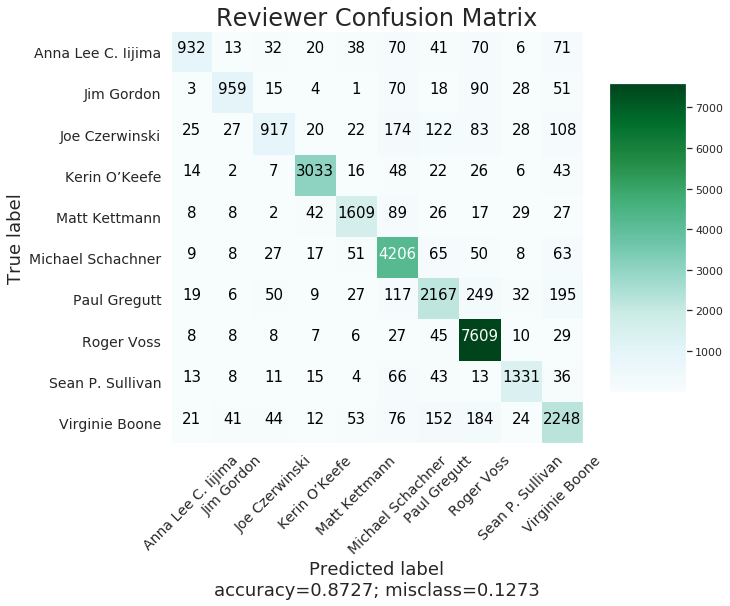

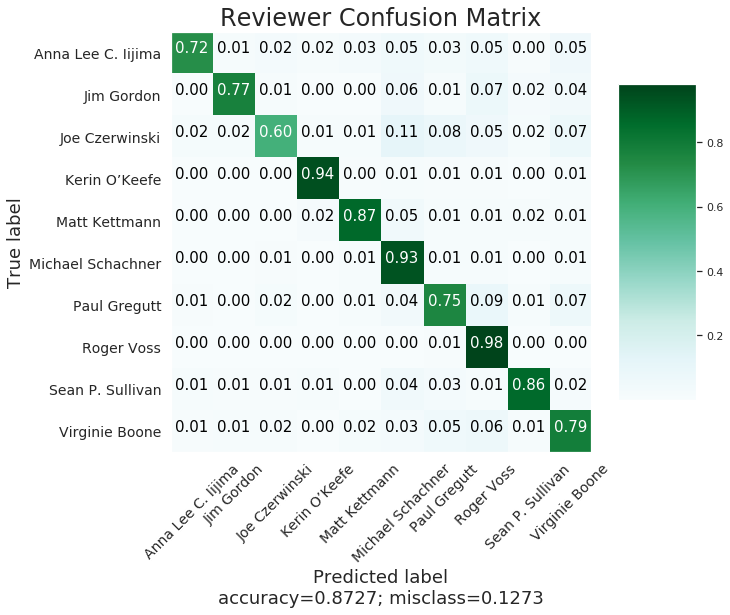

In [46]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Shown with decimals: Normalized confusion matrix")
    else:
        print('Shown with Intergers: Confusion matrix, without normalization')

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), size = 18)

    
# get unique reviewer name in the dataset
reviewer_list = wine_narrow_model_10['taster_name']
c = Counter(reviewer_list)
reviewer = sorted([taster_name for taster_name in c if c[taster_name] > 1 ])
# plot the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = reviewer,
                      normalize=False, title = 'Reviewer Confusion Matrix', cmap = plt.cm.BuGn)
plot_confusion_matrix(cm, classes = reviewer,
                      normalize=True, title = 'Reviewer Confusion Matrix', cmap = plt.cm.BuGn)

#### Learning: 
we also used the features importance using the mean decrease impurity to view the top 25 features for the model

[Text(0, 0.5, 'Feature')]

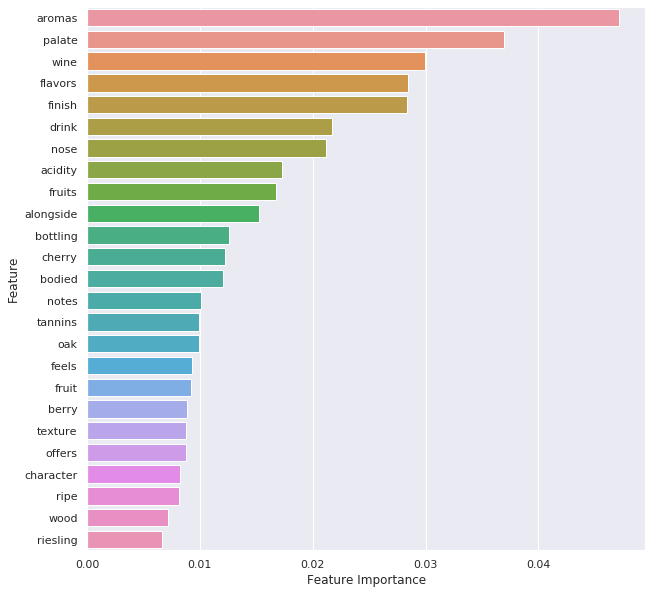

In [47]:
# plot the top 25 features  
# turn the dtm matrix to a numpy array to sum the columns  
pred_feat_array = pred_feat_unigrams.toarray()
pred_feat_nored = pd.DataFrame(pred_feat_array, columns = vectorizer_count.get_feature_names()) 
feature_names = np.array(pred_feat_nored.columns)   
df_featimport = pd.DataFrame([i for i in zip(feature_names, 
                                             rforest_model.feature_importances_)],
                             columns=["features","importance"])  
  
# plot out the top 25 features of our model  
# here we are using the mean decrease impurity: impurity decrease from each feature, averaged and ranked
# evaluate the diff in accuracy between predictions to find the lost accuracy if a feature is random noise.
# note that for features that are correlated, when one of them is used, the other one's importance is reduced significantly
# since the impurity can be removed is already done by the first feature. (not an issue for reducing overfitting)
# this is something to keep in mind when interpreting the data
# We can view this list as the feature's contribution to the decision of our model
plt.figure(figsize = (10, 10))
top_features = sns.barplot(x="importance", y="features", data=df_featimport.sort_values('importance', ascending=False)[0:25])  
top_features.set(xlabel='Feature Importance')  
top_features.set(ylabel='Feature')  

In [48]:
# this report is used to measure the quality of the predictions:
# true positives, false positives, true negatives, false negatives
# Precision – What pct of your predictions were correct?, Accuracy of positive predictions, TP/(TP + FP)
# Recall – What pct of the positive cases did you catch?, ability to find all positive instances, TP/(TP + FN) 
# F1 score – What pct of positive predictions were correct?, weighted mean for 2*(Recall*Precision)/(Recall+Precision) 
# Support: distribution of each class
print("=== Classification Report ===")
print(classification_report(y_test, rf_predictions))
print('\n')
# calculate accuracy of class predictions
print("=== Accuracy of class predictions ===")
print("Accuracy: %.2f%%" % ((metrics.accuracy_score(y_test, rf_predictions)) * 100))

=== Classification Report ===
                    precision    recall  f1-score   support

Anna Lee C. Iijima       0.89      0.72      0.79      1293
        Jim Gordon       0.89      0.77      0.83      1239
    Joe Czerwinski       0.82      0.60      0.69      1526
     Kerin O’Keefe       0.95      0.94      0.95      3217
     Matt Kettmann       0.88      0.87      0.87      1857
 Michael Schachner       0.85      0.93      0.89      4504
      Paul Gregutt       0.80      0.75      0.78      2871
        Roger Voss       0.91      0.98      0.94      7757
  Sean P. Sullivan       0.89      0.86      0.88      1540
    Virginie Boone       0.78      0.79      0.79      2855

         micro avg       0.87      0.87      0.87     28659
         macro avg       0.87      0.82      0.84     28659
      weighted avg       0.87      0.87      0.87     28659



=== Accuracy of class predictions ===
Accuracy: 87.27%


### Part VII: Conclusion

In this case study, we want to use the wine review descriptions to predict who the reviewers are. At the beginning of the project, exploratory data analysis (EDA) was performed to understand fill rate and level of the class for the two key features that we will be using for our model training: description and taster name. We learned that taster name (reviewer) are missing ~20% of the time and have 19 unique levels. Therefore, the decision was made to remove the rows with no taster information since that would be used as our target variable and keep only the top 10 reviewers for our case study.

Now that we have our modeling dataset, we move onto natural language process (NLP) part of the process to clean out the description words and vectorize our data to then be used as the features for the model training. For this case study, we impleted two ways of encoding the words: the normalized counts (using TF-IDF) and the straight binary indicators for each word.

After having the features ready, we then used train_test_split function to create the training and testing set from our modeling dataset. To ensure that we would get the same data split for each run of the program, we set the seed using the random_state=SEED option. For this case study, we used two modeling methods to help us predict who the reviewer is given a review descriptioin: Multinomial Naive Bayse Classifier and Random Forest.

For both models, we used the following methods to check the model accuracy: prediction accuracy, classification report, and confusion matrix. For the Random Forest model, we also utilized the feature importance information to show what are the top 25 features for the model (i.e. aroma, palate, wine, flavors, finish, etc.). When comparing the accuracy, Multinomial Naive Bayse Classifier model is ~91.26% and Random Forest model is ~87.26%. Both models seem to perform pretty well given that we have 10 levels of class for the reviewers. With Random Forest, the ability of showing top features was helpful.

This is the very first time for me using Azure ML, Python, Jupyter Notebook, and solving NLP problems all at once. It was very fascinating to learn that for both creating features from unstructured text and training the data to perform prediction class, there are many different ways and approaches to use and go after the goal, which makes sovling this type of problem fun and interesting! 